# Elasticidade de preço - Sales:

### Objetivos:
- Identificar insights sobre os produtos relacionados a  giro e faturamento
- Criar modelo de elasticidade de preços para verificar quais produtos são mais propensos ao aumento de ticket
- Mostrar impactos financeiro sobre a decisão de aumento de ticket médio
---
Para esse projeto vou utilizar a seguinte estrutura:

1. Definição do problema (Pode ser encontrada no ReadMe)
2. Coletar dados e gerar uma visão geral
3. Dividir em treinamento e teste
4. EDA - Analise exploratória de dados
5. Feature engineering, limpeza e pré processamento.
6. Treinamento de modelo e feature selection.
7. Produção final do modelo, avaliação e testes.
8. Conclusão e interpretar resultados.
9. Deploy
---
### Estrutura do Dataset:
| Coluna        | Descrição                                                           |
|---------------|---------------------------------------------------------------------|
| Sales Person  | *Nome do vendedor responsável pela transação*                       |
| Country	      | *Região de vendas ou localização da loja onde a transação ocorreu*  |
| Product       | *Nome do produto de chocolate vendido*                              |
| Date          | *A data da transação da venda de chocolate*                         |
| Amount        | *Receita total gerada a partir da venda.*                           |
| Boxes Shipped | *Número de caixas de chocolate enviadas na ordem.*              |



#### Imports

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

from elasticidadepreco.elasticidade import elasticidade

import warnings

warnings.filterwarnings('ignore')

#### Entendendo os dados

link dataset:https://www.kaggle.com/datasets/atharvasoundankar/chocolate-sales?select=Chocolate+Sales.csv

In [26]:
df = pd.read_csv('../data/raw/Chocolate Sales.csv', encoding='utf-8')

In [27]:
df.head()

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04-Jan-22,"$5,320",180
1,Van Tuxwell,India,85% Dark Bars,01-Aug-22,"$7,896",94
2,Gigi Bohling,India,Peanut Butter Cubes,07-Jul-22,"$4,501",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27-Apr-22,"$12,726",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24-Feb-22,"$13,685",184


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sales Person   1094 non-null   object
 1   Country        1094 non-null   object
 2   Product        1094 non-null   object
 3   Date           1094 non-null   object
 4   Amount         1094 non-null   object
 5   Boxes Shipped  1094 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 51.4+ KB


In [29]:
print(f'{df.shape[0]} linhas  \n{df.shape[1]} colunas')

1094 linhas  
6 colunas


In [30]:
df.describe()

,Boxes Shipped
count,1094.000000
mean,161.797989
std,121.544145
min,1.000000
25%,70.000000
50%,135.000000
75%,228.750000
max,709.000000


In [31]:
df.isnull().sum()

Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64

In [32]:
df.duplicated().sum()

0

- Vou alterar o nome de colunas para um formato mais amigavel
- E alterar os tipos para facilitar os processos
- E limpar um pouco a variavel de preço e data, para gerar analises mais precisas

In [33]:
df = df.rename(columns={
    'Sales Person': 'sales_person',
    'Country': 'country',
    'Product': 'product',
    'Date': 'date',
    'Amount': 'amount',
    'Boxes Shipped': 'boxes_shipped',
})

In [34]:
df['amount'] = df['amount'].str.replace('[\$,]', '', regex=True).str.strip().astype(int)

In [35]:
df['country'] = df['country'].astype('category')

In [36]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

In [37]:
df = elasticidade(df, 'boxes_shipped', 'amount')

- Criei uma função só pra calcular a elasticidade, pois vou trabalhar com essa nova feature como variavel dependente. Fiz essa escolha porque facilita muito o calculo da elasticidade, que é o foco aqui, não gera perigo de vazamento de dados e na implantação do projeto consigo trabalhar com novos dados criando uma etapa anterior a aplicação do modelo, vou mostrar isso na etapa de deploy

#### Divisão de treinamento e testes

- Vou splitar os dados agora para não sofrer com  vazamento de dados nem com overfitting, e para garantir que a avaliação do modelo será com dados mais próximos do cenário real (dado o projeto)

In [38]:
X = df.drop(columns=['elasticity'])
y = df['elasticity'].copy()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [40]:
print(f'X_train shape: {X_train.shape}.')
print(f'x_train shape: {y_train.shape}.')
print(f'X_test shape: {X_test.shape}.')
print(f'y_test shape: {y_test.shape}.')

X_train shape: (875, 8).
x_train shape: (875,).
X_test shape: (219, 8).
y_test shape: (219,).


#### Analise Exploratória de Dados - EDA

- Vou analisar os dados de treinos para entender melhor seu comportamento, encontrar insights sobre o negócio. ALém de procurar relacionamentos, correlações tendênciais e demais coisas que possam ajudar na modelagem e na resolução de negócios
- Vou a analise em 3 etapas, passando por uma analise univariada, bivariada e multivariada
- E aplicar bastante gráfico e visualização para ter clareza das próximas decisões que vou tomar

In [41]:
train = pd.concat([X_train, y_train], axis=1)
train.head()

,sales_person,country,product,date,amount,boxes_shipped,change_qtd,change_price,elasticity
6,Oby Sorrel,UK,99% Dark & Pure,2022-01-25,13685,176,3.631579,1.545573,2.349665
789,Ches Bonnell,New Zealand,Caramel Stuffed Bars,2022-06-30,7588,42,-0.848375,2.763889,-0.306950
1049,Ches Bonnell,India,99% Dark & Pure,2022-02-16,455,96,0.263158,-0.875240,-0.300669
837,Kaine Padly,Australia,50% Dark Bites,2022-08-02,8995,78,-0.748387,1.466411,-0.510353
661,Gunar Cockshoot,Canada,50% Dark Bites,2022-01-04,3024,23,-0.303030,0.213483,-1.419458


In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 875 entries, 6 to 860
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sales_person   875 non-null    object        
 1   country        875 non-null    category      
 2   product        875 non-null    object        
 3   date           875 non-null    datetime64[ns]
 4   amount         875 non-null    int32         
 5   boxes_shipped  875 non-null    int64         
 6   change_qtd     874 non-null    float64       
 7   change_price   874 non-null    float64       
 8   elasticity     874 non-null    float64       
dtypes: category(1), datetime64[ns](1), float64(3), int32(1), int64(1), object(2)
memory usage: 59.2+ KB


In [43]:
numeric_features = train.select_dtypes(include=[np.number])
categorical_features = train.select_dtypes(exclude=[np.number,np.datetime64])

In [44]:
for num in numeric_features:
    print(num)
    print('-' * 40)
    print(train[num].describe())
    print('-' * 40)

amount
----------------------------------------
count      875.000000
mean      5597.592000
std       4118.899392
min          7.000000
25%       2324.000000
50%       4844.000000
75%       7938.000000
max      19929.000000
Name: amount, dtype: float64
----------------------------------------
boxes_shipped
----------------------------------------
count    875.000000
mean     159.782857
std      118.855491
min        1.000000
25%       70.000000
50%      134.000000
75%      226.000000
max      709.000000
Name: boxes_shipped, dtype: float64
----------------------------------------
change_qtd
----------------------------------------
count    874.000000
mean       1.942523
std        8.625447
min       -0.994695
25%       -0.584960
50%        0.033857
75%        1.190191
max      129.500000
Name: change_qtd, dtype: float64
----------------------------------------
change_price
----------------------------------------
count    874.000000
mean       2.943408
std       16.216610
min       -0.9

In [45]:
for cat in categorical_features:
    print(cat)
    print('-' * 40)
    print(train[cat].value_counts())
    print('-' * 40)

sales_person
----------------------------------------
sales_person
Kelci Walkden          50
Brien Boise            41
Oby Sorrel             40
Van Tuxwell            40
Gigi Bohling           39
Jehu Rudeforth         39
Karlen McCaffrey       39
Dennison Crosswaite    38
Kaine Padly            38
Gunar Cockshoot        37
Curtice Advani         36
Madelene Upcott        36
Beverie Moffet         36
Ches Bonnell           36
Barr Faughny           35
Marney O'Breen         34
Roddy Speechley        34
Husein Augar           33
Mallorie Waber         33
Dotty Strutley         31
Wilone O'Kielt         30
Jan Morforth           27
Andria Kimpton         25
Rafaelita Blaksland    25
Camilla Castle         23
Name: count, dtype: int64
----------------------------------------
country
----------------------------------------
country
Australia      164
India          149
UK             146
USA            144
Canada         136
New Zealand    136
Name: count, dtype: int64
-------------------

- Dados numéricos bem espalhados, provavelmente com pouco outliers
- Vou trabalhar Date nas analises bivariada e multivariada
- A distribuição nos dados categóricos parece estar bem equilibrada também, era de se esperar vindo de um dataset do kaggle. Porém vamos prosseguir com o projeto

#### Univariada

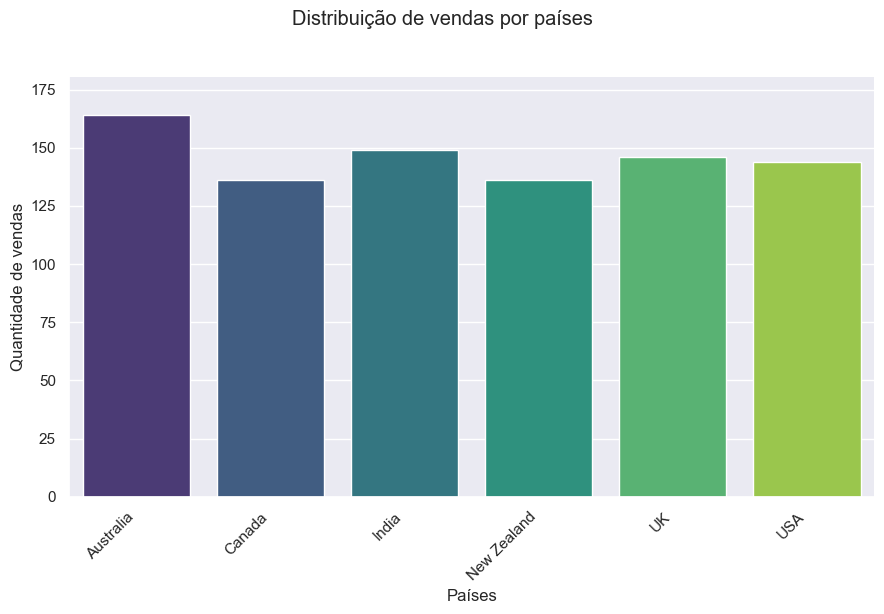

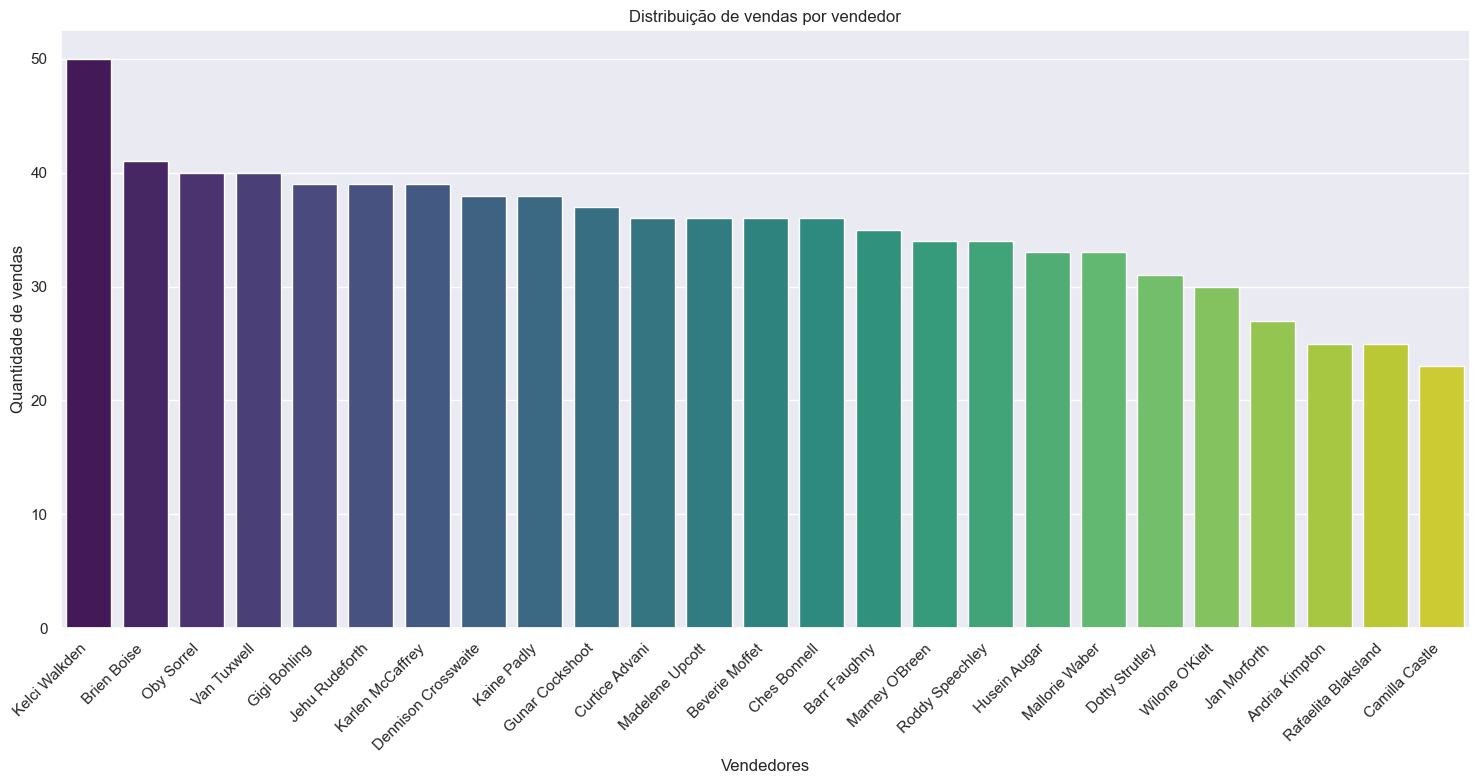

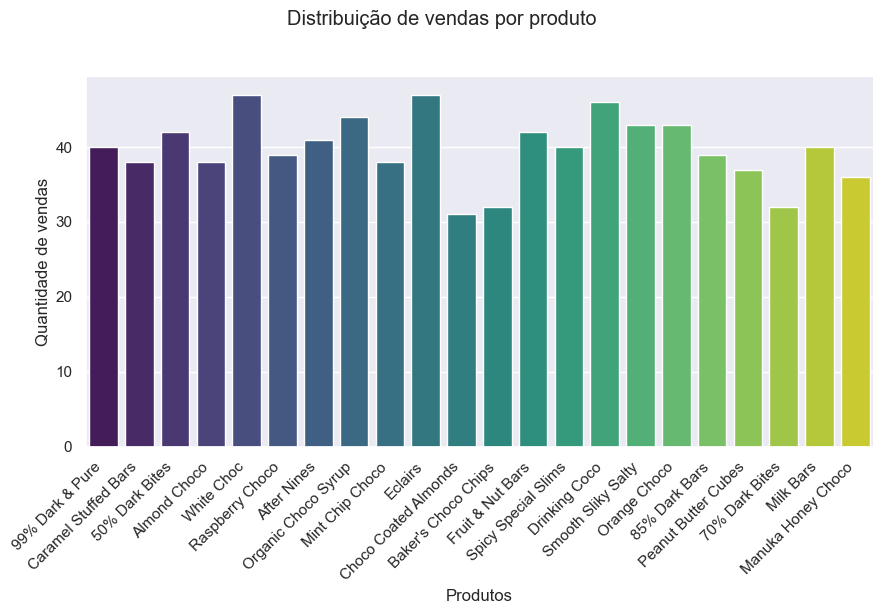

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações
qtdPaises = len(train['country'].unique())
qtdVendedores = len(train['sales_person'].unique())
qtdProdutos = len(train['product'].unique())

# Gráfico 1: Distribuição de vendas por países
g1 = sns.catplot(data=train, x='country', kind='count',
                 palette=sns.color_palette("viridis", qtdPaises),
                 height=6, aspect=1.5)
g1.set(ylim=(0, train['country'].value_counts().max() * 1.1))  # Melhor visualização
g1.set_xlabels('Países')
g1.set_ylabels('Quantidade de vendas')
g1.fig.suptitle('Distribuição de vendas por países', y=1.02)
g1.set_xticklabels(rotation=45, ha='right')
plt.tight_layout()

# Gráfico 2: Distribuição de vendas por vendedor
plt.figure(figsize=(15, 8))
g2 = sns.countplot(data=train, x='sales_person',
                   palette=sns.color_palette("viridis", qtdVendedores),
                   order=train['sales_person'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Vendedores')
plt.ylabel('Quantidade de vendas')
plt.title('Distribuição de vendas por vendedor')
plt.tight_layout()

# Gráfico 3: Distribuição de vendas por produto
g3 = sns.catplot(data=train, x='product', kind='count',
                 palette=sns.color_palette("viridis", qtdProdutos),
                 height=6, aspect=1.5)
g3.set_xlabels('Produtos')  # Corrigido
g3.set_ylabels('Quantidade de vendas')
g3.fig.suptitle('Distribuição de vendas por produto', y=1.02)
g3.set_xticklabels(rotation=45, ha='right')
plt.tight_layout()

plt.show()